# Ex3 - Raz Bareli

### Q1)

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns

In [262]:
df = pd.read_csv("ex3.csv")

We'll take only the features we want to work with:

In [263]:
df = df[['state','date','congressional_district','gun_type','participant_gender', 'n_killed']]

In order to work with the data, we have to fill null values, and do some data engineering as we did in previous exercises, so that's what we'll do first.
I saw in the forum that you said it's not the essence of the exercise, but I don't see any other way to handle the data without it. So I'll do some basic
operations just so I could train models on the data.

In [264]:
# fill null values with mode as in ex1:
for column in df:
    df[column] = df[column].fillna(df[column].mode()[0])

In [265]:
# modify 'participant_gender' as in ex2
df.loc[df['participant_gender'].str.contains('Female', regex=True) & df['participant_gender'].str.contains('Male', regex=True), ['participant_gender']] = "Both"
df.loc[df['participant_gender'].str.contains('Female', regex=True), ['participant_gender']] = "Female"
df.loc[df['participant_gender'].str.contains('Male', regex=True), ['participant_gender']] = "Male"


In [266]:
# modify 'gun_type' as in ex2
df['Gun']=df.gun_type.str.extract('([A-Za-z]+|[0-9][mm]+)')
def combine_guns(x):
    if x in ["Handgun","9mm","0mm", "Win","Spl", "Spr"]:
        return 'Handgun'
    if x in ["Other", "Unknown"]:
        return 'Unknown'
    else:
        return 'Rifle'
df["Gun"] = df["Gun"].apply(lambda x:combine_guns(x))
df['gun_type'] = df['Gun']
df = df.drop(columns='Gun')

In [267]:
# modify date to year as in ex1
def delete_day_year(x):
    return x[:-6]
df['date'] = df['date'].apply(delete_day_year)

Now we can get to the model training part:

In [268]:
# create dummy variables
# ive changed the names so it will be possible to un-dummie the database later on
df.rename(columns = {'participant_gender':'gender', 'congressional_district':'district',
                              'gun_type':'gun', 'n_killed': 'killed'}, inplace = True)
needs_ohe = ['state', 'date', 'gun', 'gender']
df = pd.get_dummies(df, columns=needs_ohe)

In [269]:
X = df.drop(columns=['killed'])
y = df['killed']

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

I'll choose 2 models:
1. Linear Regression
2. Random Forest

Both are Regression models since we are trying to predict an integer between 0 and inf.
We could, technically,  have taken a multiclass classifier in that case, but I don't think that it suits here
since there are hierarchies between the classes. That is, 10 killed are much more than 2 killed.
So that's why I've picked regression models.

For the metric I'll choose the MSE metric.
The advantage of MSE is that it gives different weights to large errors and small errors.
That is, a larger error in our prediction (say, we predicted 100 instead of 1) will increase the MSE more that a smaller
prediction error (if we predicted 2 instead of 1).

One disadvantage of this metric is that we can't really tell how many times we were wrong. For instance,
If we predict everything wrong, say: 1 instead of 0 and 0 instead of 1, the MSE won't be large, but obviously the prediction is very bad.
In this case, the accuracy metric would have an advantage since it would have told us that we are 100% wrong.

In [271]:
# linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_mse =  mean_squared_error(y_test, lr_y_pred)
print("MSE for Linear Regression = ", lr_mse)

MSE for Linear Regression =  0.24076792403292574


In [272]:
# random forest
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_y_pred = rfr.predict(X_test)
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
print("MSE for Random Forest Regression = ", rfr_mse)

MSE for Random Forest Regression =  0.2729124591049397


As we can see, the errors are not too large and both models performed pretty much the same, when comparing with the MSE metric.
However, I think that since most of the n_killed data is either 0 or 1, most of the predictions are in that area as well,
And as I explained before, it's hard to tell just based of one metric if the predictions were good, since they can all be wrong
in the worst case, and still get a relatively low MSE.

### Q2)

For this question I'll continue with the Random Forest Regressor from Q1, so we can see if we can improve the model by
hyperparameter selection.

I'll use Grid Search and Random Search.

I've chosen 3 hyperparameters and 2 values for each, and cv=3 in cross validation - only because otherwise it would take way too
long to run (even with these settings it can take up to 10 minutes on my PC).

Ideally, I would have chosen 4 parameters as the exersice suggests, and more values for each parameter, as well as cv=5 cross validation
which is the standard from what I understand.

I've chosen the MSE score, for the same reasons I've mentioned earlier, and so I'll be able to compare it to the results in Q1.

In [273]:
# Grid Search
gs_rfr = RandomForestRegressor()
params_grid = {
    'n_estimators': [10, 100],
    'max_depth': [20, 50],
    'min_samples_split': [5, 20],
}
n_combinations = np.array([len(l) for key, l in params_grid.items()]).prod() # to use in random grid search
gs = GridSearchCV(estimator=gs_rfr, param_grid=params_grid, verbose=3, cv=3, scoring=make_scorer(mean_squared_error, greater_is_better = False))
gs.fit(X_train, y_train)

print('Best parameters: ', gs.best_params_)
print('Best Score: ', abs(gs.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_depth=20, min_samples_split=5, n_estimators=10;, score=-0.246 total time=   0.4s
[CV 2/3] END max_depth=20, min_samples_split=5, n_estimators=10;, score=-0.263 total time=   0.4s
[CV 3/3] END max_depth=20, min_samples_split=5, n_estimators=10;, score=-0.257 total time=   0.4s
[CV 1/3] END max_depth=20, min_samples_split=5, n_estimators=100;, score=-0.243 total time=   4.1s
[CV 2/3] END max_depth=20, min_samples_split=5, n_estimators=100;, score=-0.258 total time=   4.5s
[CV 3/3] END max_depth=20, min_samples_split=5, n_estimators=100;, score=-0.249 total time=   4.9s
[CV 1/3] END max_depth=20, min_samples_split=20, n_estimators=10;, score=-0.240 total time=   0.4s
[CV 2/3] END max_depth=20, min_samples_split=20, n_estimators=10;, score=-0.256 total time=   0.4s
[CV 3/3] END max_depth=20, min_samples_split=20, n_estimators=10;, score=-0.246 total time=   0.4s
[CV 1/3] END max_depth=20, min_samples_split=20, n_e

In [274]:
# Random Grid Search:
rgs_rfr = RandomForestRegressor()

ranges = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(20, 50),
    'min_samples_split': randint(5, 20)
}
rgs = RandomizedSearchCV(estimator=rgs_rfr, param_distributions=ranges, verbose=3, cv=3,  scoring=make_scorer(mean_squared_error, greater_is_better = False), n_iter=n_combinations)
rgs.fit(X_train, y_train)

print('Best parameters: ', rgs.best_params_)
print('Best Score: ', abs(rgs.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_depth=25, min_samples_split=7, n_estimators=48;, score=-0.245 total time=   2.3s
[CV 2/3] END max_depth=25, min_samples_split=7, n_estimators=48;, score=-0.260 total time=   2.3s
[CV 3/3] END max_depth=25, min_samples_split=7, n_estimators=48;, score=-0.250 total time=   2.5s
[CV 1/3] END max_depth=49, min_samples_split=5, n_estimators=19;, score=-0.263 total time=   1.0s
[CV 2/3] END max_depth=49, min_samples_split=5, n_estimators=19;, score=-0.274 total time=   1.1s
[CV 3/3] END max_depth=49, min_samples_split=5, n_estimators=19;, score=-0.262 total time=   1.1s
[CV 1/3] END max_depth=21, min_samples_split=13, n_estimators=94;, score=-0.238 total time=   4.0s
[CV 2/3] END max_depth=21, min_samples_split=13, n_estimators=94;, score=-0.253 total time=   4.1s
[CV 3/3] END max_depth=21, min_samples_split=13, n_estimators=94;, score=-0.243 total time=   4.1s
[CV 1/3] END max_depth=22, min_samples_split=14, n_esti

Well, we can see that the grid search found hyperparameters that gave a bit better results on the train set, than the random grid.
As we discussed in class - since this is random, the opposite could happen if we'll run it again,
since we are not limited to the values we gave the model in the first place,
and of course we need a bit of luck as well since choosing the parameter is randomly made.

Now just for fun lets compare the new fitted models to the one from question 1:


In [275]:
print("question 1 forest error: ", rfr_mse)
print("grid search forest error: ", mean_squared_error(y_test, gs.predict(X_test)))
print("random grid search forest error: ", mean_squared_error(y_test, rgs.predict(X_test)))

question 1 forest error:  0.2729124591049397
grid search forest error:  0.24302462881449252
random grid search forest error:  0.2448067427154033


And we can see that the hyperparamater optimization led to a better results!

### Q3.a)

We'll use the Random Forest Regressor from previous question, with the hyperparameters we've found to perform best.
This time well train it on all the original dataset (without cross validation).
Please Note that since this is a random forest, without setting the seed at the beginning of the program, results can change
between runs. So, when running the program on another PC, some statements that I've made regarding better or worse score, can change.

In [276]:
rfr_q3 = gs.best_estimator_
rfr_q3.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=20)

In [277]:
y_pred = rfr_q3.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  0.24293981237008988


Now we'll show the importance, as we learned in class:

In [278]:
feature_importances = sorted(list(zip(X_train.columns, rfr_q3.feature_importances_)), key=lambda x: -x[1])

Now, in order to show the data in a bar plot, we need to combine all the "new features" from the one-hot-encoding process
to their original features. That's what I'll do next:

In [279]:
def most_important(data):
    feature_importances_dict = {'state' : 0, 'gender':0, 'district':0, 'date':0, 'gun':0}
    for i in data:
        curr_feature = None
        if i[0].startswith('state'):
            curr_feature = 'state'
        elif i[0].startswith('gender'):
            curr_feature = 'gender'
        elif i[0].startswith('district'):
            curr_feature = 'district'
        elif i[0].startswith('date'):
            curr_feature = 'date'
        elif i[0].startswith('gun'):
            curr_feature = 'gun'
        feature_importances_dict[curr_feature] += i[1]
    return feature_importances_dict

In [280]:
feature_importances_dict = most_important(feature_importances)
features = list(feature_importances_dict.keys())
importances = list(feature_importances_dict.values())
most_important_feature = features[importances.index(max(importances))]
least_important_feature = features[importances.index(min(importances))]
most_important_feature

'state'

<AxesSubplot:>

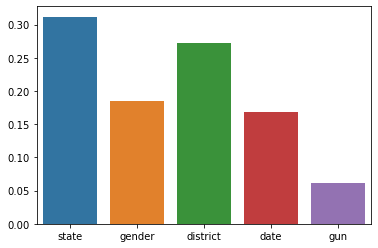

In [281]:
sns.barplot(x=features, y=importances)

### 3.b)

Model without the most important feature:
First we'll have to reverse the one hot encoding process, to eliminate the date feature (function taken from stackoverflow):

In [282]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [283]:
# reverse and drop state
df_1 = undummify(df)
df_1 = df_1.drop(columns=most_important_feature)

In [284]:
# now we'll do one hot encoding again:
needs_ohe_1 = needs_ohe.copy()
if most_important_feature in needs_ohe:
    needs_ohe_1.remove(most_important_feature)
df_1 = pd.get_dummies(df_1, columns=needs_ohe_1)

In [285]:
X =  df_1.drop(columns='killed')
y = df_1['killed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [286]:
rfr_1 = gs.best_estimator_
rfr_1.fit(X_train, y_train)
y_pred = rfr_1.predict(X_test)

In [287]:
print("MSE for model without most important feature = ", mean_squared_error(y_test, y_pred))

MSE for model without most important feature =  0.2585138229776014


And we can see the MSE is a little bit higher (worse), as expected.
As for the new important features:


<AxesSubplot:>

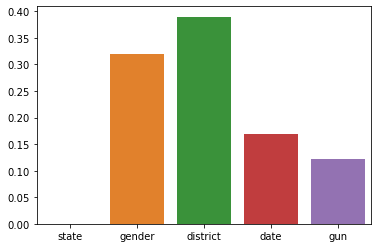

In [288]:
feature_importances_1 = sorted(list(zip(X_train.columns, rfr_1.feature_importances_)), key=lambda x: -x[1])
feature_importances_dict_1 = most_important(feature_importances_1)
features_1 = list(feature_importances_dict_1.keys())
importances_1 = list(feature_importances_dict_1.values())
sns.barplot(x=features_1, y=importances_1)

Now we'll train a model with the 4 most important features, that is:
state, district, date, gender.

In [289]:
# reverse and drop state
df_2 = undummify(df)
df_2 = df_2.drop(columns=least_important_feature)

In [290]:
# now we'll do one hot encoding again:
needs_ohe_2 = needs_ohe.copy()
if least_important_feature in needs_ohe:
    needs_ohe_2.remove(least_important_feature)
df_2 = pd.get_dummies(df_2, columns=needs_ohe_2)

In [291]:
X =  df_2.drop(columns='killed')
y = df_2['killed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [292]:
rfr_2 = gs.best_estimator_
rfr_2.fit(X_train, y_train)
y_pred = rfr_2.predict(X_test)

In [293]:
print("MSE for model with top 4 most important features = ", mean_squared_error(y_test, y_pred))

MSE for model with top 4 most important features =  0.24742947979913008


The MSE improved a bit, as expected, since now we have the 4 top most important features.
As for the new most important features:

<AxesSubplot:>

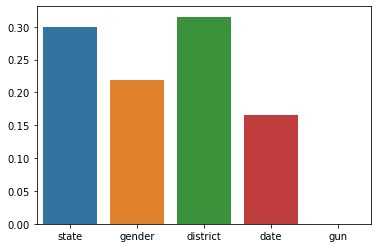

In [294]:
feature_importances_2 = sorted(list(zip(X_train.columns, rfr_2.feature_importances_)), key=lambda x: -x[1])
feature_importances_dict_2 = most_important(feature_importances_2)
features_2 = list(feature_importances_dict_2.keys())
importances_2 = list(feature_importances_dict_2.values())
sns.barplot(x=features_2, y=importances_2)

### Question 4
First, a quick look of the raw data.
It doesn't seem like there are non relevant points in the column that we are trying to predict. The percentage of
samples that are outside the range [0 : 4] is negligible.

In [295]:
y.value_counts()

0    23241
1     6131
2      524
3       74
4       22
5        5
6        1
9        1
8        1
Name: killed, dtype: int64

Also, the other data columns are not numerical, but strings, and they have been pre-processed by me to fit the data.
For example, I know that the only possibilities for gender are 'Male', 'Female', and 'Both'.
So I would not expect to have big anomalies in the data at this point. For raw data it could have been a different case.

I try to find some using the isolation forest we've seen in class:

In [296]:
isf = IsolationForest()
isf.fit(X_train)
pd.Series(isf.predict(X_train)).value_counts()

1    20100
dtype: int64

And as expected, there no apparent anomalies in the data.
In order to answer this question more properly, I'll load a new dataset with numeric values, and
without too much pre-processing:

In [297]:
df = pd.read_csv("ex3.csv")

In [298]:
df = df[['date','longitude','latitude', 'n_killed', 'n_injured', 'congressional_district','n_guns_involved']]
for column in df:
    df[column] = df[column].fillna(df[column].mode()[0])
def delete_day_year(x):
    return int(x[:-6])
df['date'] = df['date'].apply(delete_day_year)
df.head()

,date,longitude,latitude,n_killed,n_injured,congressional_district,n_guns_involved
0,2017,-123.8700,40.7450,0,0,2.0,1.0
1,2015,-84.0148,33.9997,0,0,7.0,1.0
2,2017,-77.8066,35.9934,0,0,2.0,1.0
3,2016,-102.3410,31.8876,0,0,11.0,5.0
4,2015,-73.4185,40.6923,1,2,2.0,1.0


In [299]:
X = df.drop(columns=['n_killed'])
y = df['n_killed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [300]:
isf = IsolationForest()
isf.fit(X_train)
pd.Series(isf.predict(X_train)).value_counts()

 1    16812
-1     3288
dtype: int64

And that's a different result from the previous one.
That does make sense, since we know that we have some inaccurate numbers in the latitude and longitude columns, for example.

Let's try a different technique we saw in class:


In [301]:
from statsmodels.genmod.generalized_linear_model import GLM
model = GLM(y,X).fit()

(array([2.9979e+04, 1.2000e+01, 2.0000e+00, 3.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.04862939e-05, 1.42856026e-01, 2.85701566e-01, 4.28547106e-01,
        5.71392646e-01, 7.14238186e-01, 8.57083725e-01, 9.99929265e-01,
        1.14277481e+00, 1.28562034e+00, 1.42846588e+00]),
 <BarContainer object of 10 artists>)

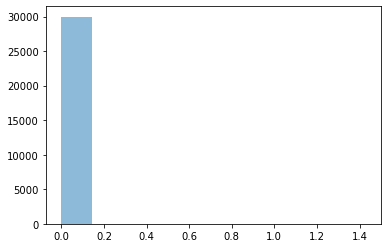

In [302]:
plt.hist(model.get_influence(observed=False).summary_frame()['dffits_internal'].abs(),alpha=.5)

This result shows that there are no anomalies in the data, or in other words - no influence points.
That's of course, not true - and I think that the reason we can't see it in the GLM model
is due to the fact that it's a very bad model for this data.
And since everything is a mess - there are no points that appear unusual in the data.
So, if we had data that can be a good fit overall for a linear model, then it would have been easier to spot
unusual points within it.